In [ ]:
!pip install pybullet
!pip install gymnasium pybullet stable-baselines3[extra]

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [16]:
class CupGraspingEnv(gym.Env):
    def __init__(self):
        super(CupGraspingEnv, self).__init__()

        self.client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # AXYZ 이동 + 그리퍼
        action_bound = 0.1
        self.action_space = spaces.Box(
            low=np.array([-action_bound]*3 + [0]),
            high=np.array([action_bound]*3 + [1]),
            shape=(4,),
            dtype=np.float32
        )

        # Observation Space : 그리퍼(3), 컵(3), 관절각도(9), 그리퍼 상태(1), 상대위치(3) -> 총 19차원
        obs_dim = 3 + 3 + 9 + 1 + 3
        obs_low = np.array([-np.inf] * obs_dim)
        obs_high = np.array([np.inf] * obs_dim)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.robotId = None
        self.cupId = None
        self.end_effector_index = 8 # Panda 로봇의 손목 바로 위 링크
        self.gripper_indices = [9, 10] # Panda 로봇의 손가락 관절
        self.distance_to_cup = 0
        self.max_steps_per_episode = 500
        self.step_counter = 0
        print("맞춤형 Gym 환경이 [Panda Grasping 버전]으로 생성되었습니다!")

    def reset(self, seed=None, options=None):
        self.step_counter = 0
        p.resetSimulation(physicsClientId=self.client)
        p.setGravity(0, 0, -9.8)

        p.loadURDF("plane.urdf")
        self.robotId = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0], useFixedBase=True)

        # 1. '커리큘럼 학습'을 위해 컵 위치를 고정
        cup_start_pos = [0.5, 0.2, 0.05]
        cup_visual_shape = p.createVisualShape(p.GEOM_CYLINDER, radius=0.04, length=0.1, rgbaColor=[0.8, 0.2, 0.2, 1])
        cup_collision_shape = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.04, height=0.1)
        self.cupId = p.createMultiBody(baseMass=0.1, baseCollisionShapeIndex=cup_collision_shape, baseVisualShapeIndex=cup_visual_shape, basePosition=cup_start_pos)

        # 마찰력을 설정
        p.changeDynamics(self.cupId, -1, lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[0], lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[1], lateralFriction=1.0)

        observation = self._get_obs()
        self.distance_to_cup = np.linalg.norm(self.gripper_pos - self.cup_pos)

        info = {}
        return observation, info

    def step(self, action):
        # action 벡터를 이동과 잡기 부분으로 분리
        move_action = action[:3]  # XYZ 이동량
        grasp_action = action[3]   # 그리퍼 제어 (0~1 사이 값)

        current_gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        current_gripper_pos = np.array(current_gripper_state[0])
        target_position = current_gripper_pos + move_action
        target_joint_angles = p.calculateInverseKinematics(self.robotId, self.end_effector_index, target_position)

        if target_joint_angles:
            p.setJointMotorControlArray(
                bodyIndex=self.robotId,
                jointIndices=range(self.end_effector_index + 1), # 0~6번 팔 관절
                controlMode=p.POSITION_CONTROL,
                targetPositions=target_joint_angles[:self.end_effector_index + 1]
            )

        target_gripper_pos = 0.00 if grasp_action > 0.5 else 0.04
        p.setJointMotorControlArray(
            bodyIndex=self.robotId,
            jointIndices=self.gripper_indices, # 그리퍼 관절만 제어
            controlMode=p.POSITION_CONTROL,
            targetPositions=[target_gripper_pos] * len(self.gripper_indices)
        )

        p.stepSimulation()

        observation = self._get_obs()
        reward = self._compute_reward()
        terminated = self._check_done()
        info = {}
        return observation, reward, terminated, False, info

    def _get_obs(self):
        gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        self.gripper_pos = np.array(gripper_state[0])

        cup_pos, _ = p.getBasePositionAndOrientation(self.cupId)
        self.cup_pos = np.array(cup_pos)

        joint_states = p.getJointStates(self.robotId, range(p.getNumJoints(self.robotId)))

        # Panda 로봇의 움직이는 관절 9개(팔 7 + 그리퍼 2)
        joint_positions = [state[0] for state in joint_states][:9]
        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])
        gripper_opening = np.array([gripper_joint_state[0]])
        # 그리퍼에서 컵을 향하는 '상대 위치 벡터'를 계산하여 추가
        relative_pos = self.cup_pos - self.gripper_pos
        # 계산된 relative_pos를 observation에 포함
        observation = np.concatenate([self.gripper_pos, self.cup_pos, joint_positions, gripper_opening, relative_pos])

        return observation

    def _compute_reward(self):
        reward = 0
        new_distance = np.linalg.norm(self.gripper_pos - self.cup_pos)

        # 접근 보상
        reward += (self.distance_to_cup - new_distance) * 100
        self.distance_to_cup = new_distance

        # 시간 페널티
        reward -= 1

        # 접촉 보상: 그리퍼와 컵이 실제로 접촉했는지 확인하고 추가 보상
        contact_points = p.getContactPoints(bodyA=self.robotId, bodyB=self.cupId)
        if len(contact_points) > 0:
            print("컵과 접촉!")
            reward += 100 # 접촉 시 보너스 점수

        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])
        is_gripper_closing = gripper_joint_state[0] < 0.01 # 그리퍼가 닫히는 중인지 확인
        if is_gripper_closing:
            print("잡기 시도!")
            reward += 200 # '좋은 시도'에 대한 추가 보너스

        # 컵이 테이블에서 성공적으로 들어 올려졌는지 확인
        cup_pos, _ = p.getBasePositionAndOrientation(self.cupId)
        if cup_pos[2] > 0.05: # 컵의 Z좌표가 초기 높이(0.05)보다 높아졌다면
            print("성공! 컵을 들어 올렸습니다!")
            reward += 5000

        # 컵 넘어짐 페널티
        _, cup_orn = p.getBasePositionAndOrientation(self.cupId)
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            reward -= 500

        return reward

    def _check_done(self):
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cupId)

        if cup_pos[2] > 0.1:
            return True

        # 실패 또는 시간 초과 조건
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            return True

        self.step_counter += 1
        if self.step_counter > self.max_steps_per_episode:
            return True

        return False

    def render(self):
        view_matrix = p.computeViewMatrix(cameraEyePosition=[1,1,1], cameraTargetPosition=[0.5,0,0.5], cameraUpVector=[0,0,1])
        proj_matrix = p.computeProjectionMatrixFOV(fov=60.0, aspect=1.0, nearVal=0.1, farVal=100.0)
        (w, h, rgb, _, _) = p.getCameraImage(width=224, height=224, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
        return rgb

    def close(self):
        if self.client >= 0:
            p.disconnect(self.client)
            self.client = -1
        print("PyBullet 시뮬레이션 연결이 종료되었습니다.")

In [ ]:
# --- AI 훈련 실행 코드 ---
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

try:
    print("--- AI 훈련 시작 (Grasping 버전) ---")

    env = CupGraspingEnv()

    checkpoint_callback = CheckpointCallback(
      save_freq=50000,
      save_path='./logs/',
      name_prefix='ppo_cup_grasper_v1'
    )

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        gamma=0.99,            # 미래 보상 할인율
        learning_rate=0.0001,  # 학습률
        n_steps=4096
    )

    model.learn(total_timesteps=1000000, callback=checkpoint_callback)
    model.save("ppo_cup_grasper_v1_final")
    print("--- 훈련 완료 및 최종 모델 저장 ---")

finally:
    env.close()

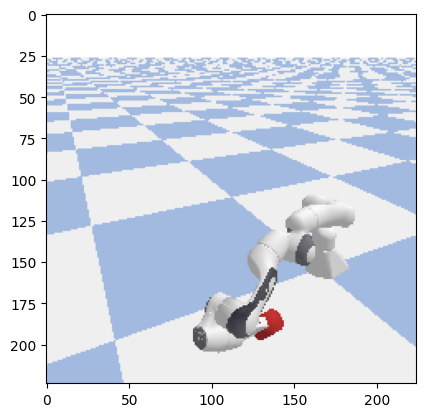

테스트 스텝: 311, 보상: 4600.0229, 종료 여부: True
--- 최종 성공! 컵 들어 올리기 완료! ---
PyBullet 시뮬레이션 연결이 종료되었습니다.
--- 테스트 종료 ---


In [25]:
try:
    print("\n--- 훈련된 AI 테스트 시작 ---")


    model_path = "logs/ppo_cup_grasper_v1_100000_steps.zip"
    trained_model = PPO.load(model_path)

    test_env = CupGraspingEnv()
    obs, info = test_env.reset()

    for i in range(1000):
        action, _states = trained_model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = test_env.step(action)

        # 화면 보기
        clear_output(wait=True)
        plt.imshow(test_env.render())
        plt.show()

        print(f"테스트 스텝: {i+1}, 보상: {reward:.4f}, 종료 여부: {terminated}")

        if terminated:
            if reward > 4000: # 성공 보너스
                print("--- 최종 성공! 컵 들어 올리기 완료! ---")
            else:
                print("--- 에피소드 실패 또는 시간 초과 ---")

            time.sleep(5)
            break

finally:
    test_env.close()
    print("--- 테스트 종료 ---")